<a href="https://colab.research.google.com/github/roshkjr/DeepLearning/blob/main/PDBe_ligand_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://www.ebi.ac.uk/pdbe/sites/default/files/2019-04/PDBe-letterhead-charcoal-RGB_2013.png)

# PDBe tools for ligand analysis and visualisation
## Introduction
Welcome to this Google Colab notebook, showcasing specialized tools developed by the Protein Data Bank in Europe (PDBe) to analyse small-molecules in PDB. We will explore:

1.   **[PDBe CCDUtils](https://github.com/PDBeurope/ccdutils)**: A small-molecule toolkit for accessing and enriching ligand data

2.   **[PDBe Arpeggio](https://github.com/PDBeurope/arpeggio)**: Analysing interactions between ligands and macromolecules
3.   **[PDBe RelLig](https://github.com/PDBeurope/rellig)**: Identifying the functional roles of ligands, such as reactants, cofactors, and drugs

  ## Instructions <a name="Instructions"></a>

* Quick Start <a name="Quick Start"></a>

In order to make the learning experience more accessible and interactive, we have incorporated widgets that allow you to provide inputs and customize certain aspects of the code. These widgets serve as interactive elements that enhance your ability to interact with the code and observe the impact of different inputs on the results. Throughout this tutorial, you will come across code chunks that include these interactive widgets.

  * How to use Google Colab <a name="Google Colab"></a>
1. To run a code cell, click on the cell to select it. You will notice a play button (▶) on the left side of the cell. Click on the play button or press Shift+Enter to run the code in the selected cell.
2. The code will start executing, and you will see the output, if any, displayed below the code cell.
3. Move to the next code cell and repeat steps 2 and 3 until you have executed all the desired code cells in sequence.
4. The currently running step is indicated by a circle with a stop sign next to it.
If you need to stop or interrupt the execution of a code cell, you can click on the stop button (■) located next to the play button.

*Remember to run the code cells in the correct order, as their execution might depend on variables or functions defined in previous cells. You can modify the code in a code cell and re-run it to see updated results.*

## Contact us

Requests for clarifications or reporting bugs can be made via pdbehelp@ebi.ac.uk.

#&nbsp; 1.  PDBe CCDUtils
## Introduction
PDBe CCDUtils is an open-source python package for processing and analyzing small molecules in the PDB. Small-molecule data in the PDB is available as [Chemical Component Dictionary (CCD)](http://www.wwpdb.org/data/ccd) or [Biologically Interesting Molecule reference Dictioanry (BIRD)](http://www.wwpdb.org/data/bird) in PDBX/mmCIF format. PDBe CCDUtils provides streamlined access to all metadata of small molecules in the PDB and offers a set of convenient methods to compute various properties using RDKIt such as

* [Physicochemical properties](#accessing-properties-of-CCD)
* [Matching common fragments and scaffolds](#finding-fragments-and-scaffolds)
* [Mapping to small-molecule databases using UniChem](#fetching-external-mappings-to-other-databases)
* [2D depictions](#2D-Depictions)
* [Similarity using PARITY method](#similarity-using-parity-method)
* [Export to multiple formats](#export-to-different-formats)


PDBe CCDUtils also provides methods for identifying all the Covalently Linked Chemical components (CLC) in a macromolecular structure. To findout more, please refer to the publication [PDBe CCDUtils: an RDKit-based toolkit for handling and analysing small molecules in the Protein Data Bank](https://doi.org/10.1186/s13321-023-00786-w)

## Install dependencies

In [94]:
%pip install rdkit pdbeccdutils wget

## Helper functions

In [2]:
import os
import gzip
import requests
from enum import Enum
from typing import NamedTuple
import pandas as pd
from collections import defaultdict
from typing import List, Set, Dict
from gemmi import cif
from pdbeccdutils.core.component import Component

In [3]:
BASE_URL = "https://ftp.ebi.ac.uk/pub/databases/msd"
PDBECHEM_URL = f"{BASE_URL}/pdbechem_v2"
ENTRY_URL = f"{BASE_URL}/updated_mmcif/all"
ASSEMBLY_URL = f"{BASE_URL}/assemblies/all"

class ligandType(Enum):
    CCD = "ccd"
    PRD = "prd"
    CLC = "clc"

class Subcomponent(NamedTuple):
    id: int
    name: str
    atoms: list[str]


def get_ligand_cif(ligand_id: str, ligand_type: ligandType) -> str:
    """
    Downloads and writes ligand CIF from PDBe FTP to a file
    and returns the path

    Args:
        ligand_id: ID of the ligand
        ligand_type: Type of ligand

    Returns:
        The path to cif file of ligand
    """
    match ligand_type.value:
        case "ccd":
            ligand_dir = os.path.join("ccd", ligand_id[0], ligand_id)
        case "prd":
            ligand_dir = os.path.join("prd", ligand_id[-1],ligand_id)
        case "clc":
            ligand_dir = os.path.join("clc", ligand_id[-1],ligand_id)
    try:
        ligand_cif_path = os.path.join(PDBECHEM_URL, ligand_dir, f"{ligand_id}.cif")
        response = requests.get(ligand_cif_path)
        assert response.status_code == 200
        ligand_cif_file = os.path.join(os.getcwd(), f"{ligand_id}.cif")
        with open(ligand_cif_file, "wb") as fh:
            fh.write(response.content)

        return ligand_cif_file
    except  AssertionError:
        print(f"Couldn't find the file. Check if {ligand_id} & {ligand_type} are valid, if so try again")


def get_entry_cif(pdb_id: str) -> str:
    """
    Downloads and writes PDB entry updated mmCIF to a file and
    returns the path

    Args:
        pdb_id: PDB id of an entry

    Returns:
        path to the downloaded cif file
    """
    entry_url = os.path.join(ENTRY_URL, f"{pdb_id}_updated.cif.gz")
    response = requests.get(entry_url, stream=True)
    response.raise_for_status()
    with open(f"{pdb_id}_updated.cif", "wb") as fh:
        fh.write(gzip.decompress(response.content))

    return f"{pdb_id}_updated.cif"

def get_subcomponents(component: Component) -> List[Subcomponent]:
    """
    Returns a list of subcomponents present in a
    multi-component ligand

    Args:
        component: Component object of small molecule
    """
    mol = component.mol_no_h
    atoms = defaultdict(list)
    for atom in mol.GetAtoms():
        if not atom.HasProp("residue_id"):
            continue
        else:
            res_id = atom.GetProp("residue_id")
            res_info = atom.GetPDBResidueInfo()
            res_name = res_info.GetResidueName()
            atoms[(res_id, res_name)].append(atom.GetProp("name"))

    subcomponents = [Subcomponent(id=key[0],
                                  name = key[1],
                                  atoms = values,
                                ) for key, values in atoms.items()]
    return subcomponents


##&nbsp; 1.1  Reading small molecule data

In [ ]:
from pdbeccdutils.core import ccd_reader

In [ ]:
hem_cif = get_ligand_cif("HEM", ligandType.CCD)
hem =  ccd_reader.read_pdb_cif_file(hem_cif)
hem

CCDReaderResult(warnings=[], errors=[], component=<pdbeccdutils.core.component.Component object at 0x7b9661fb5d20>, sanitized=True)

CCDReaderResult contains a component object - the core structural representation of small-molecules in PDBe CCDUtils. Component is a wrapper around rdkit.Chem.rdchem.Mol object providing most of its functionality and access metada data from CCD file.

In [ ]:
hem_component = hem.component

##&nbsp; 1.2 Accessing properties of CCD

Properties in the CCD file and physicochemical properties generated by RDKit can be accessed using attributes of the Component object

In [ ]:
print(f"""
id: {hem_component.id}
name: {hem_component.name}
formula: {hem_component.formula}
inchi: {hem_component.inchi}
inchikey: {hem_component.inchikey}
release status: {hem_component.pdbx_release_status.name}
modified_date: {hem_component.modified_date}
""")


id: HEM
name: PROTOPORPHYRIN IX CONTAINING FE
formula: C34 H32 Fe N4 O4
inchi: InChI=1S/C34H34N4O4.Fe/c1-7-21-17(3)25-13-26-19(5)23(9-11-33(39)40)31(37-26)16-32-24(10-12-34(41)42)20(6)28(38-32)15-30-22(8-2)18(4)27(36-30)14-29(21)35-25;/h7-8,13-16H,1-2,9-12H2,3-6H3,(H4,35,36,37,38,39,40,41,42);/q;+2/p-2/b25-13-,26-13-,27-14-,28-15-,29-14-,30-15-,31-16-,32-16-;
inchikey: KABFMIBPWCXCRK-RGGAHWMASA-L
release status: REL
modified_date: 2024-09-27



In [ ]:
hem_component.descriptors

[Descriptor(type='SMILES', program='ACDLabs', program_version='12.01', value='C=1c3c(c(c4C=C5C(=C(C=6C=C7C(=C(C8=CC=2C(=C(C=1N=2[Fe](n34)(N5=6)N78)CCC(=O)O)C)\\C=C)C)\\C=C)C)C)CCC(=O)O'),
 Descriptor(type='InChI', program='InChI', program_version='1.03', value='InChI=1S/C34H34N4O4.Fe/c1-7-21-17(3)25-13-26-19(5)23(9-11-33(39)40)31(37-26)16-32-24(10-12-34(41)42)20(6)28(38-32)15-30-22(8-2)18(4)27(36-30)14-29(21)35-25;/h7-8,13-16H,1-2,9-12H2,3-6H3,(H4,35,36,37,38,39,40,41,42);/q;+2/p-2/b25-13-,26-13-,27-14-,28-15-,29-14-,30-15-,31-16-,32-16-;'),
 Descriptor(type='InChIKey', program='InChI', program_version='1.03', value='KABFMIBPWCXCRK-RGGAHWMASA-L'),
 Descriptor(type='SMILES_CANONICAL', program='CACTVS', program_version='3.385', value='CC1=C(CCC(O)=O)C2=Cc3n4[Fe]5|6|N2=C1C=c7n5c(=CC8=N|6C(=Cc4c(C)c3CCC(O)=O)C(=C8C=C)C)c(C)c7C=C'),
 Descriptor(type='SMILES', program='CACTVS', program_version='3.385', value='CC1=C(CCC(O)=O)C2=Cc3n4[Fe]5|6|N2=C1C=c7n5c(=CC8=N|6C(=Cc4c(C)c3CCC(O)=O)C(=C8C=C)C

In [ ]:
hem_component.physchem_properties

{'exactmw': 616.177293004001,
 'amw': 616.4990000000015,
 'lipinskiHBA': 8.0,
 'lipinskiHBD': 2.0,
 'NumRotatableBonds': 12.0,
 'NumHBD': 2.0,
 'NumHBA': 8.0,
 'NumHeavyAtoms': 43.0,
 'NumAtoms': 75.0,
 'NumHeteroatoms': 9.0,
 'NumAmideBonds': 0.0,
 'FractionCSP3': 0.23529411764705882,
 'NumRings': 6.0,
 'NumAromaticRings': 2.0,
 'NumAliphaticRings': 4.0,
 'NumSaturatedRings': 0.0,
 'NumHeterocycles': 6.0,
 'NumAromaticHeterocycles': 2.0,
 'NumSaturatedHeterocycles': 0.0,
 'NumAliphaticHeterocycles': 4.0,
 'NumSpiroAtoms': 0.0,
 'NumBridgeheadAtoms': 6.0,
 'NumAtomStereoCenters': 1.0,
 'NumUnspecifiedAtomStereoCenters': 0.0,
 'labuteASA': 296.33725284003606,
 'tpsa': 96.26000000000002,
 'CrippenClogP': 6.210060000000007,
 'CrippenMR': 165.27259999999967,
 'chi0v': 21.879585517566603,
 'chi1v': 13.71303192500862,
 'chi2v': 11.67144422171997,
 'chi3v': 11.67144422171997,
 'chi4v': 10.931337280412357,
 'chi0n': 52.775400934448555,
 'chi1n': 27.554303075888956,
 'chi2n': 7.046175792189254,

##&nbsp; 1.3 Fetching external mappings to other databases

In [ ]:
external_mappings = hem_component.fetch_external_mappings(all_mappings=True)
external_mappings

[('DrugBank', 'DB18267'),
 ('PDBe', 'HEM'),
 ('BRENDA', '135197'),
 ('MedChemExpress', 'HY-111914A'),
 ('BRENDA', '228486'),
 ('BRENDA', '228485'),
 ('BRENDA', '48'),
 ('BRENDA', '8254'),
 ('BRENDA', '143348'),
 ('BRENDA', '822'),
 ('BRENDA', '211503'),
 ('EPA CompTox Dashboard', 'DTXSID90889386'),
 ('HMDB', 'HMDB0003178'),
 ('MetaboLights', 'MTBLC26355'),
 ('BRENDA', '3360'),
 ('MetaboLights', 'MTBLC17627'),
 ('BRENDA', '30062'),
 ('BRENDA', '144129'),
 ('BRENDA', '1517'),
 ('SureChEMBL', 'SCHEMBL4008'),
 ('PubChem TPHARMA', '14912106'),
 ('fdasrs', '42VZT0U6YR'),
 ('ChEBI', '26355'),
 ('Probes And Drugs', 'PD158908'),
 ('ChEBI', '17627')]

##&nbsp; 1.4 Finding fragments

PDBe CCDUtils supports search for fragments present in a small molecule from a library of fragments. The fragment library present in PDBe CCDUtils contains 2158 fragments which were manually currated at PDBe and collaborating resources (ENAMINE, DSI). Should you wish to check all the fragments, please check [fragment_library.tsv](https://github.com/PDBeurope/ccdutils/blob/master/pdbeccdutils/data/fragment_library.tsv) file.

In [ ]:
from pdbeccdutils.core.fragment_library import FragmentLibrary
from rdkit.Chem import Draw

In [ ]:
fragment_library = FragmentLibrary()

In [ ]:
fragment_matches = hem_component.library_search(fragment_library)
print(f"No of fragments found: {len(fragment_matches)}")

No of fragments found: 0


In [ ]:
fragment_matches

[]

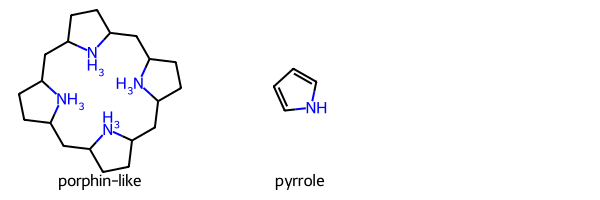

In [ ]:
fragment_mols = [fragment.mol for fragment in hem_component.fragments]
img = Draw.MolsToGridImage(fragment_mols, legends = [fragment.name for fragment in hem_component.fragments])
img

##&nbsp; 1.5 Finding scaffolds

PDBe CCDUtils supports identification of scaffolds of small moelcules in PDB using the RDKit functionality. Currently it supports three types of scaffolding methods
* MurckoScaffold
* MurckoScaffoldGeneric
* BRICS

In [ ]:
from pdbeccdutils.core.models import ScaffoldingMethod

In [ ]:
murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoScaffold)
generic_murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoGeneric)
brics_scaffolds = hem_component.get_scaffolds(scaffolding_method=ScaffoldingMethod.Brics)

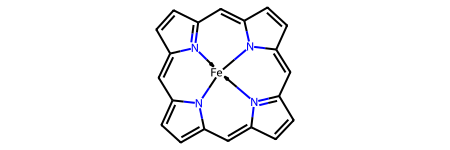

In [ ]:
murcko_scaffolds[0]

##&nbsp; 1.6 2D Depictions

PDBe CCDUtils uses [template-based](https://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html#rdkit.Chem.rdDepictor.GenerateDepictionMatching2DStructure) and [connectivity based](https://rdkit.org/docs/source/rdkit.Chem.rdCoordGen.html) methods from RDKit to generate 2D depictions of small moelcules. Templates can either be downloaded from PubChem or provided as a path to a folder containing SDF files. A hand-curated set of [ten templates](https://github.com/PDBeurope/ccdutils/tree/master/pdbeccdutils/data/general_templates) are also provided with PDBe CCDUtils

To find the best depiction of a small molecule, a heuristic-based Depiction Penalty Score (DPS) is defined. A DPS of zero indicates a high-quality 2D depiction, while higher scores indicate lower quality.

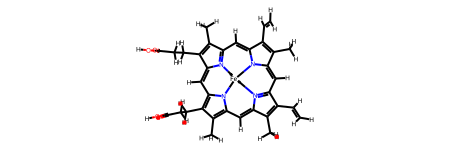

In [ ]:
hem_component.mol

In [ ]:
from pdbeccdutils.core.depictions import DepictionManager
from pdbeccdutils.utils.pubchem_downloader import PubChemDownloader
from IPython.core.display import SVG

In [ ]:
pubchem_templates = os.getcwd()
pubchem_downloader = PubChemDownloader(pubchem_templates)

In [ ]:
pubchem_downloader.process_template(hem_component)
depictions = DepictionManager(pubchem_templates)
depiction_result = hem_component.compute_2d(depictions)
depiction_result

[20:25:38] unrecognized bond type[20:25:38] unrecognized bond type[20:35:13] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


DepictionResult(source=<DepictionSource.Template: 2>, template_name='hem', mol=<rdkit.Chem.rdchem.RWMol object at 0x7b96607e04f0>, score=0.0)

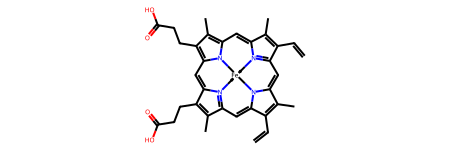

In [ ]:
hem_component.mol2D

In [ ]:
hem_component.export_2d_svg("hem.svg", width=400)

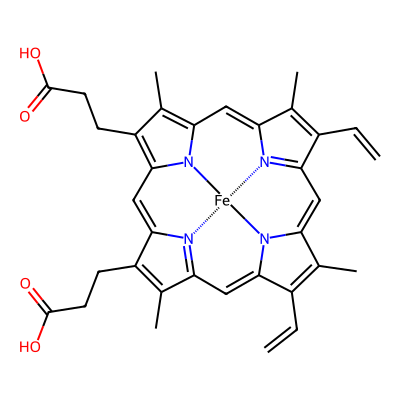

In [ ]:
SVG("hem.svg")

##&nbsp; 1.6.1 Highlighting substructures

Atoms and bonds of substructures (fragments and scaffolds) can be highligted on the 2D depiction of small molecules using *export_2d_svg* method of Component object. The atoms to highlight can be passed as a dictionary with atom names as keys and the color as values. Similarly the bonds to highlight can be passed as a dictionary of atom names of bonds as a tuple and colors as values.
The below example shows how to highlight the Murcko scaffold of **HEM**.

In [ ]:
atom_color = (0.5, 0.5, 0.5, 0.4)
bond_color = (0.5, 0.5, 0.5, 0.8)
hem_murcko_scaffold = murcko_scaffolds[0]
athighlights = {atom.GetProp("name"):atom_color for atom in hem_murcko_scaffold.GetAtoms()}
bndhighlights = {(bond.GetBeginAtom().GetProp("name"), bond.GetEndAtom().GetProp("name")): bond_color for bond in hem_murcko_scaffold.GetBonds()}
hem_component.export_2d_svg("hem_scaffold.svg", atom_highlight=athighlights, bond_highlight=bndhighlights, width=400)

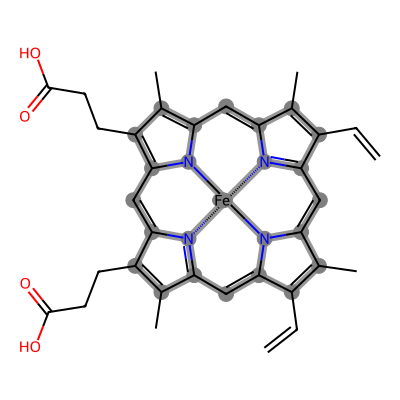

In [ ]:
SVG("hem_scaffold.svg")

##&nbsp; 1.7 Similarity using PARITY method

PDBe CCDUtils supports comparison of small moelcules based on [PARITY](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5890617/) similarity score. PARITY represents the proportion of atoms of same type residing in identical topology between two small molecules

In [ ]:
from pdbeccdutils.computations.parity_method import compare_molecules

In [ ]:
heme_acetyl_cif = get_ligand_cif("HCO", ligandType.CCD)
heme_acetyl_component = ccd_reader.read_pdb_cif_file(heme_acetyl_cif).component

In [ ]:
similarity = compare_molecules(hem_component.mol_no_h, heme_acetyl_component.mol_no_h)

In [ ]:
similarity

ParityResult(mapping={0: 1, 4: 9, 5: 10, 6: 11, 7: 12, 38: 5, 42: 0, 40: 7, 21: 27, 2: 3, 17: 22, 39: 6, 14: 19, 1: 2, 15: 20, 16: 21, 19: 24, 20: 25, 18: 23, 22: 28, 23: 29, 24: 30, 3: 4, 28: 34, 41: 8, 31: 37, 30: 36, 29: 35, 32: 38, 33: 39, 34: 40, 35: 41, 36: 42, 37: 43, 26: 32, 27: 33, 25: 31, 8: 13, 9: 14, 10: 15, 11: 16, 12: 17, 13: 18}, similarity_score=0.9772727272727273)

##&nbsp; 1.8 Export to different formats

PDBe CCDUtils presently supports exporting of small molecule data to the following formats
* CIF
* PDB
* SDF
* CML

In [ ]:
from pdbeccdutils.core import ccd_writer

In [ ]:
ccd_writer.write_molecule("hem.sdf",
                          hem_component,
                          )

In [ ]:
ccd_writer.write_molecule("hem.pdb",
                          hem_component,
                          )

##&nbsp; 1.9 Use cases

###&nbsp; 1.9.1 Fetching DrugBank details

The enriched CIF files of small molecules available from [PDBeChem FTP](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2) contains data fetched from DrugBank. This information can be accessed by parsing approriate category in the CIF files. The below example shows how to fetch DrugBank details of **IMATINIB**

In [ ]:
sti_cif = get_ligand_cif("STI", ligandType.CCD)
sti_component = ccd_reader.read_pdb_cif_file(sti_cif).component

In [ ]:
def get_drugbank_synonyms(component: Component) -> Set[str]:
    """
    Returns synonyms from DrugBank

    Args:
        component: Component object of small molecule
    """

    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_synonyms." not in cif_block.get_mmcif_category_names():
        return
    synonyms = set()
    synonyms_table = cif_block.find("_pdbe_chem_comp_synonyms.", ["name", "provenance"])
    for row in synonyms_table:
        if row["_pdbe_chem_comp_synonyms.provenance"] == "DrugBank":
            synonyms.add(cif.as_string(row["_pdbe_chem_comp_synonyms.name"]))
    return synonyms

In [ ]:
synonyms = get_drugbank_synonyms(sti_component)
synonyms

{'Celonib',
 'Enliven',
 'Imatib',
 'Imatinib',
 'Imatinibum',
 'Mesylonib',
 'Mitinab',
 'Plivatinib',
 'Shantinib',
 "α-(4-methyl-1-piperazinyl)-3'-((4-(3-pyridyl)-2-pyrimidinyl)amino)-p-toluidide"}

In [ ]:
def get_drugbank_classification(component: Component) -> Dict[str, str]:
    """
    Returns DrugBank classification details

    Args:
        component: Component object of small molecule
    """
    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_drugbank_classification." not in cif_block.get_mmcif_category_names():
        return
    items = ["description", "kingdom", "superclass", "class", "parent"]
    classification = {item: cif.as_string(cif_block.find_value(f"_pdbe_chem_comp_drugbank_classification.{item}")) for item in items}
    return classification

In [ ]:
get_drugbank_classification(sti_component)

{'description': "This compound belongs to the class of organic compounds known as benzanilides. These are aromatic compounds containing an anilide group in which the carboxamide group is substituted with a benzene ring. They have the general structure RNC(=O)R', where R,R'= benzene.",
 'kingdom': 'Organic compounds',
 'superclass': 'Benzenoids',
 'class': 'Benzene and substituted derivatives',
 'parent': 'Benzanilides'}

In [ ]:
def get_drugbank_details(component: Component):
    """
    Returns details from DrugBank such as name, id,
    description etc.

    Args:
        component: Component object of small molecule

    """
    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_drugbank_details." not in cif_block.get_mmcif_category_names():
        return
    items = ["drugbank_id", "name", "description", "mechanism_of_action"]
    details = defaultdict(list)
    for item in items:
        details["info"].append(item)
        details["value"].append(cif.as_string(cif_block.find_value(f"_pdbe_chem_comp_drugbank_details.{item}")))
    synonyms = get_drugbank_synonyms(component)
    details["info"].append("synonyms")
    details["value"].append(', '.join(synonyms))
    details_df = pd.DataFrame.from_dict(details)
    return details_df


In [ ]:
pd.set_option('display.max_colwidth', None)
get_drugbank_details(sti_component)

,info,value
0,drugbank_id,DB00619
1,name,Imatinib
2,description,"Imatinib is a small molecule kinase inhibitor that revolutionized the treatment of cancer, particularly chronic myeloid leukemia, in 2001.[A249305] It was deemed a ""miracle drug"" due to its clinical success, as oncologist Dr. Brian noted that ""complete hematologic responses were observed in 53 of 54 patients with CML treated with a daily dosage of 300 mg or more and typically occurred in the first four weeks of therapy"".[A249315]. The discovery of imatinib also established a new group of therapy called ""targeted therapy"", since treatment can be tailored specifically to the unique cancer genetics of each patient.[L42220] Imatinib was approved on February 1st ,2001 by the FDA and November 7th, 2001 by the EMA; however, its European approval has been withdrawn in October 2023.[A263036,L49746,L49751]"
3,mechanism_of_action,"Imatinib mesylate is a protein-tyrosine kinase inhibitor that inhibits the BCR-ABL tyrosine kinase, the constitutively active tyrosine kinase created by the Philadelphia chromosome abnormality in CML.[L42080]Although the function of normal BCR is still unclear, ABL activation is overexpressed in various tumors and is heavily implicated in cancer cells growth and survival.[A249305,A249310] Imatinib inhibits the BCR-ABL protein by binding to the ATP pocket in the active site, thus preventing downstream phosphorylation of target protein.[A249305] Imatinib is also an inhibitor of the receptor tyrosine kinases for platelet-derived growth factor (PDGF) and stem cell factor (SCF), c-Kit, and inhibits PDGF- and SCF-mediated cellular events. In vitro, imatinib inhibits proliferation and induces apoptosis in GIST cells, which express an activating c-Kit mutation.[L42080]"
4,synonyms,"α-(4-methyl-1-piperazinyl)-3'-((4-(3-pyridyl)-2-pyrimidinyl)amino)-p-toluidide, Imatinibum, Plivatinib, Enliven, Celonib, Imatinib, Mesylonib, Mitinab, Imatib, Shantinib"


In [ ]:
def get_drugbank_targets(component: Component) -> pd.DataFrame:
    """
    Returns target information from DrugBank

    Args:
        component: Component object of small molecule
    """
    cif_block = component.ccd_cif_block
    if "_pdbe_chem_comp_drugbank_targets." not in cif_block.get_mmcif_category_names():
        return
    items = ["name", "organism", "uniprot_id", "pharmacologically_active"]
    targets = cif_block.find("_pdbe_chem_comp_drugbank_targets.", items)
    targets_info = defaultdict(list)
    for row in targets:
        for item in items:
            targets_info[item].append(cif.as_string(row[f"_pdbe_chem_comp_drugbank_targets.{item}"]))
    targets_df = pd.DataFrame.from_dict(targets_info)
    return targets_df


In [ ]:
get_drugbank_targets(sti_component)

,name,organism,uniprot_id,pharmacologically_active
0,Breakpoint cluster region protein,Humans,P11274,yes
1,Mast/stem cell growth factor receptor Kit,Humans,P10721,yes
2,Proto-oncogene tyrosine-protein kinase receptor Ret,Humans,P07949,yes
3,High affinity nerve growth factor receptor,Humans,P04629,unknown
4,Macrophage colony-stimulating factor 1 receptor,Humans,P07333,unknown
5,Platelet-derived growth factor receptor alpha,Humans,P16234,yes
6,Epithelial discoidin domain-containing receptor 1,Humans,Q08345,unknown
7,Tyrosine-protein kinase ABL1,Humans,P00519,yes
8,Platelet-derived growth factor receptor beta,Humans,P09619,yes
9,Discoidin domain-containing receptor 2,Humans,Q16832,unknown


###&nbsp; 1.9.2 Idenitfying Covalently Linked Components from a PDB entry

In some PDB entries, large ligands are fragmented to smaller CCDs. For example in PDB entry [1e55](https://www.ebi.ac.uk/pdbe/entry/pdb/1e55), the competitive inhibitor **dhurrin** is in compelx with the structure, but it is split into two different CCDs - BGC and DHR. This happens due to the current wwwPDB annotation policies, which recommend splitting of large ligands to smaller CCDs to allow identification of correct stereospecificities and geometry. However, this practise obscures the small molecule data in the PDB archive and make it difficult to automatically identify and map to other databases.

At PDBe, we have created a process to identify these fragmented ligands in the PDB and assign a unique identifier based on the inchikey. You can access them from [PDBeChem FTP](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/clc/). You can also use PDBe CCDUtils to create the complete representaiton of fragmented ligands in a PDB entry.

In [95]:
from pdbeccdutils.helpers import cif_tools
from pdbeccdutils.core.boundmolecule import infer_bound_molecules
from pdbeccdutils.core import clc_reader

In [ ]:
def get_clc(pdb_id: str) -> list[clc_reader.CLCReaderResult]:
    """
    Returns a list of CLCReaderResults containing Component
    object of Covalently Linked Components (CLCs)

    Args:
        pdb_id: PDB ID of an entry

    """
    input_cif = get_entry_cif(pdb_id)
    fixed_mmcif_file = os.path.join(f"{pdb_id}_processed.cif")

    #Keeps only first model, removes alternate conformations of atoms and residues
    cif_tools.fix_updated_mmcif(input_cif, fixed_mmcif_file)

    #
    bms = infer_bound_molecules(
    fixed_mmcif_file, ["HOH"], assembly=False
)
    clc_reader_results = []
    for i, bm in enumerate(bms, start=1):
        bm_id = f"bm{i}"
        reader_result = clc_reader.infer_multiple_chem_comp(
            fixed_mmcif_file, bm, bm_id, sanitize=True
        )
        if reader_result:
            clc_reader_results.append(reader_result)

    return clc_reader_results


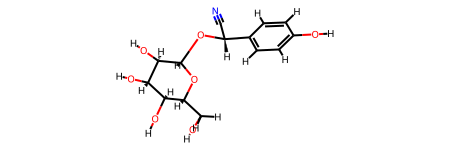

In [ ]:
clc_reader_results = get_clc("1e55")
dhurrin_component = clc_reader_results[0].component
dhurrin_component.mol

In [ ]:
dhurrin_component.fetch_external_mappings(all_mappings=True)

[('SureChEMBL', 'SCHEMBL50174'),
 ('PubChem', '161355'),
 ('eMolecules', '32231621'),
 ('PubChem TPHARMA', '24422914'),
 ('fdasrs', 'P5999IY65C'),
 ('NMRShiftDB', '60025950'),
 ('HMDB', 'HMDB0060471'),
 ('Rhea', '27826'),
 ('BRENDA', '30532'),
 ('BRENDA', '1121'),
 ('MetaboLights', 'MTBLC27826'),
 ('ChEBI', '27826'),
 ('KEGG LIGAND', 'C05143'),
 ('EPA CompTox Dashboard', 'DTXSID90198142'),
 ('ZINC', 'ZINC000004096638'),
 ('Nikkaji', 'J10.589I')]

Instead of creating the complete representation of fragmented ligands from PDB entries, you can find the standardized IDs of these ligands from [interacting_chains_with_ligand_functions.tsv](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/additional_data/pdb_ligand_interactions/interacting_chains_with_ligand_functions.tsv) available from FTP. The below example shows how this can be done for the entry **1e55**.

In [34]:
import wget
from pdbeccdutils.core import clc_reader

In [ ]:
interacting_chains = os.path.join(PDBECHEM_URL, "additional_data", "pdb_ligand_interactions", "interacting_chains_with_ligand_functions.tsv")
wget.download(interacting_chains)

'interacting_chains_with_ligand_functions.tsv'

In [ ]:
int_chain_ligand = pd.read_csv("interacting_chains_with_ligand_functions.tsv", sep="\t")
int_chain_ligand.head()

,PDBID,Chain_Symmetry,BestUnpAccession,bmID,inchikey,LigandID,LigandType,annotation
0,100d,A,NaN,bm1,PFNFFQXMRSDOHW-UHFFFAOYSA-N,SPM,CCD,NaN
1,101d,A,NaN,bm1,JLVVSXFLKOJNIY-UHFFFAOYSA-N,MG,CCD,ion
2,101d,A,NaN,bm2,IDBIFFKSXLYUOT-UHFFFAOYSA-N,NT,CCD,NaN
3,101d,B,NaN,bm1,JLVVSXFLKOJNIY-UHFFFAOYSA-N,MG,CCD,ion
4,101d,B,NaN,bm2,IDBIFFKSXLYUOT-UHFFFAOYSA-N,NT,CCD,NaN


In [ ]:
int_chain_ligand[int_chain_ligand["PDBID"]=="1e55"]

,PDBID,Chain_Symmetry,BestUnpAccession,bmID,inchikey,LigandID,LigandType,annotation
14747,1e55,A,P49235,bm1,NVLTYOJHPBMILU-YOVYLDAJSA-N,CLC_000189,CLC,NaN
14748,1e55,B,P49235,bm2,NVLTYOJHPBMILU-YOVYLDAJSA-N,CLC_000189,CLC,NaN


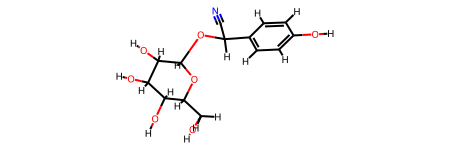

In [ ]:
durrin_cif = get_ligand_cif("CLC_000189", ligandType.CLC)
dhurrin_cif_component = clc_reader.read_clc_cif_file(durrin_cif).component
dhurrin_cif_component.mol

####&nbsp; 1.9.2.1 Highlighting CCDs present in a Covalently Linked Component (CLC)

In [ ]:
pubchem_downloader.process_template(dhurrin_cif_component)
depictions = DepictionManager(pubchem_templates)
depiction_result = dhurrin_cif_component.compute_2d(depictions)
depiction_result

[20:35:13] unrecognized bond type[20:35:13] unrecognized bond type[20:43:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


DepictionResult(source=<DepictionSource.PubChem: 1>, template_name='CLC_000189', mol=<rdkit.Chem.rdchem.Mol object at 0x7b965a85f610>, score=0.0)

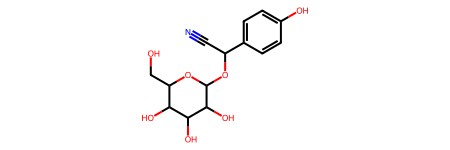

In [ ]:
dhurrin_cif_component.mol2D

In [ ]:
dhurrin_subcomponents = get_subcomponents(dhurrin_cif_component)
dhurrin_subcomponents

[Subcomponent(id='1', name='BGC', atoms=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'O6', 'O7', 'O8', 'O9', 'O10', 'O11']),
 Subcomponent(id='2', name='DHR', atoms=['N12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'O20', 'C21'])]

In [ ]:
subcomponent_colors = [(0.0, 0.0, 1.0, 0.5), (1.0, 0.0, 0.0, 0.5)]
athighlights ={}
bndhighlights = {}
for i, subcomponent in enumerate(dhurrin_subcomponents):
    for atom in subcomponent.atoms:
        athighlights[atom] = subcomponent_colors[i]
    for bond in dhurrin_cif_component.mol.GetBonds():
        bgn_atom = bond.GetBeginAtom().GetProp("name")
        end_atom = bond.GetEndAtom().GetProp("name")
        if bgn_atom in subcomponent.atoms and end_atom in subcomponent.atoms:
            bndhighlights[(bgn_atom, end_atom)] = subcomponent_colors[i]

In [ ]:
dhurrin_cif_component.export_2d_svg("dhurrin_ccd.svg", atom_highlight=athighlights, bond_highlight=bndhighlights)

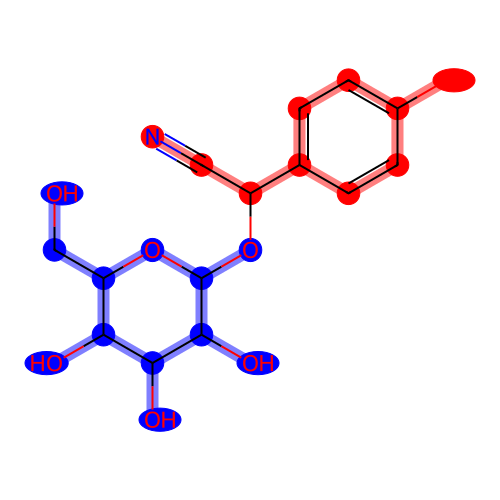

In [ ]:
SVG("dhurrin_ccd.svg")

###&nbsp; 1.9.3 Analysis of Drug-like molecules in PDB

In [ ]:
drug_like_molecules = int_chain_ligand.loc[int_chain_ligand["annotation"]=="drug-like", "LigandID"].unique()
drug_like_molecules

array(['BME', 'MES', 'SAH', ..., 'A1AIL', 'A1APA', 'COC'], dtype=object)

In [ ]:
ccd_component_cif = os.path.join(PDBECHEM_URL, "ccd", "components.cif")
wget.download(ccd_component_cif)

'components.cif'

In [ ]:
ccd_components = ccd_reader.read_pdb_components_file("components.cif")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#Filter based on number of atoms
drug_like_with_heavy_atoms = []
for ccd in drug_like_molecules:
    num_heavy_atoms = ccd_components[ccd].component.physchem_properties.get("NumHeavyAtoms", 0)
    if num_heavy_atoms > 6:
        drug_like_with_heavy_atoms.append(ccd)


In [ ]:
drug_like_weights = []
for ccd in drug_like_with_heavy_atoms:
    if "exactmw" in ccd_components[ccd].component.physchem_properties:
        drug_like_weights.append(ccd_components[ccd].component.physchem_properties["exactmw"])

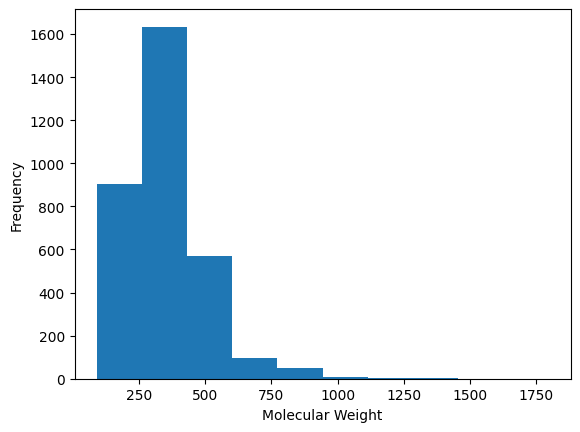

In [ ]:
plt.hist(drug_like_weights)
plt.xlabel("Molecular Weight")
plt.ylabel("Frequency")
plt.show()

#&nbsp; 2. PDBe Arpeggio

## Introduction

PDBe Arpeggio is an open-source python package to calculate interatomic interactions between macromolecules and ligands from their 3D structures. Currently the library only supports macromolecule-ligand complexes in mmCIF format.

In this notebook, we will analyse the protein-ligand interactions present in the crystal structure of hexameric P4 ATPase from bacteriophage $\phi$12 in complex with ATP analog (APC - $\alpha$,$\beta$-methyleneadenosine-5'-triphosphate) from the PDB entry [1w48](https://pdbe.org/1w48). The model file for this PDB entry is a homo trimer and the biological assembly is a homo hexamer. There are 6 instances of ligand APC binding at the interface of adjacent subunits of the PDB entry on the outer surface. We will calculate the interactions between the protein and APC, and identify important interaction types and residues in the binding pocket.

Before running the interaction calculations using PDBe Arpeggio, the protein-ligand complex need to be prepared. The preparation steps usually involves:
- Selecting an appropriate model of PDB entry if there are multiple models
- Selecting appropriate conformations of atoms and residues, if there are multiple conformations present
- Creating biological assembly of the model
- Protonating the strcuture in an appropriate pH for the analysis

For the sake of this tutorial, we will use the protonated biological assembly of PDB ID: [1w48](https://pdbe.org/1w48)) available from PDBe static file server. This file is generated by
- Selecting the first model if there are multiple models
- Keeping only the conformation with maximum occupancy
- Creating biological assembly using [Model Server](https://molstar.org/docs/data-access-tools/model-server/)
- Protonating at pH 7.4 using [ChimeraX](https://www.rbvi.ucsf.edu/chimerax/)


   

## Installation of dependencies

In [96]:
# install openbabel
!apt-get install openbabel

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openbabel is already the newest version (3.1.1+dfsg-6ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Official python bindings of OpenBabel had issues with installation using PyPI as of writing of this notebook. Please see the [issue](https://github.com/openbabel/openbabel/issues/2571). Hence, a pre-built unofficial openbabel-wheel is used here

In [97]:
# install pdbe-arpeggio and openbabel python bindings
# openbabel-wheel is a unofficial OpenBabel prebuilt wheel distributed through PyPI
%pip install pdbe-arpeggio openbabel-wheel

## Helper Functions

In [98]:
import pandas as pd
from arpeggio.core import InteractionComplex
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
def get_protonated_preferred_assembly(pdb_id: str) -> str:
  """
    Downloads and writes protonated preferred biological
    assembly cif of PDB entry to a file and returns the path

    Args:
        pdb_id: PDB id of an entry

    Returns:
        path to the downloaded protinated cif file

  """

  assembly_url = f"https://www.ebi.ac.uk/pdbe/static/entry/download/{pdb_id}_bio_h.cif.gz"
  response = requests.get(assembly_url, stream=True)
  response.raise_for_status()
  with open(f"{pdb_id}_bio_h.cif", "wb") as fh:
    fh.write(gzip.decompress(response.content))

  return f"{pdb_id}_bio_h.cif"

In [100]:
class ProtLigComplex:
    """Wrapper for the Arpeggio computation. Parses bound molecules and
    calculates interactions.
    """

    def __init__(self, structure, to_discard=None):
        """Create protein - ligand interaction object.

        Args:
            structure (str): Path to the structure to be processed
            to_discard (list, optional): Defaults to []. list of residue
                names to be discarded prior to protein-ligand interaction
                lookup.
        """
        self.compl = None
        self.path = structure

        to_discard = [] if to_discard is None else to_discard

    def initialize(self):
        """Set up Arpeggio basics. Create all the internal representation"""
        self.compl = InteractionComplex(self.path)
        self.compl.structure_checks()
        self.compl.address_ambiguities()
        self.compl.initialize()

    def get_interaction(
        self,
        bm,
        interaction_cutoff=5.0,
        compensation_factor=0.1,
        include_neighbors=False,
    ):
        """Retrieve interactions in the protein within a given selection.

        Args:
            bm (BoundMolecule): Bound molecule
            interaction_cutoff (float, optional): Defaults to 5.0. Distance
                cutoff for grid points to be `interacting` with the entity.
            compensation_factor (float, optional): Defaults to 0.1.
                Compensation factor for VdW radii dependent interaction types.
            include_neighbors (bool, optional): Defaults to False. Include
                non-bonding interactions between residues that are next to
                each other in sequence.

        Returns:
            dict of str: Interactions in a dictionary like schema.
        """
        selection = bm.to_arpeggio()
        self.compl.run_arpeggio(
            selection, interaction_cutoff, compensation_factor, include_neighbors
        )

        return self.compl.get_contacts()


In [101]:
pdb_id = '1w48'
discarded_ligands = ["HOH"] #chemical components in this list are not considered as bound-molecules for interaction calculation

In [102]:
#download the protonated biological assembly
protonated_assembly = get_protonated_preferred_assembly(pdb_id)

In [103]:
#identify all the bound-molecules (ligands) in the PDB entry
bound_molecules = infer_bound_molecules(protonated_assembly, discarded_ligands, assembly=True)

In [104]:
#setup protein-ligand complex for interaction calculations
protein_lignad_complex= ProtLigComplex(protonated_assembly, discarded_ligands)
protein_lignad_complex.initialize()

#write interactions to a pandas data frame
pdb_interactions = defaultdict(list)
intx_fields = ["auth_asym_id", "auth_seq_id", "label_comp_id", "auth_atom_id"]
for i, bm in enumerate(bound_molecules, start=1):
  bm_residues = set(f"{residue['auth_asym_id']}_{residue['auth_seq_id']}_{residue['label_comp_id']}" for residue in bm.to_dict().get('residues'))
  interactions = protein_lignad_complex.get_interaction(bm)
  for intx in interactions:
    if intx["interacting_entities"] in ("INTER", "INTRA_SELECTION", "SELECTION_WATER"): # filtering interaction types
      for contact in intx["contact"]:
        pdb_interactions["interacting_entities"].append(intx["interacting_entities"])
        pdb_interactions["interaction_type"].append(intx["type"])
        pdb_interactions["distance"].append(intx["distance"])
        pdb_interactions["bm_id"].append(f"bm_{i}")
        pdb_interactions["contact_type"].append(contact)
        begin_res_id = f"{intx['bgn']['auth_asym_id']}_{intx['bgn']['auth_seq_id']}_{intx['bgn']['label_comp_id']}"
        if begin_res_id in bm_residues:
          ordered_intx_residues = {1:'bgn', 2: 'end'} #keeping bound-molecule as the first residue in the table
        else:
          ordered_intx_residues = {1:'end', 2: 'bgn'}
        for field in intx_fields:
          for order in ordered_intx_residues:
            pdb_interactions[f"{field}_{order}"].append(intx[ordered_intx_residues[order]][field])

pdb_interactions_df = pd.DataFrame.from_dict(pdb_interactions)

In [105]:
print(f"The number bound-molecules found: {len(bound_molecules)}")

The number bound-molecules found: 6


In [106]:
pdb_interactions_df.head()

,interacting_entities,interaction_type,distance,bm_id,contact_type,auth_asym_id_1,auth_asym_id_2,auth_seq_id_1,auth_seq_id_2,label_comp_id_1,label_comp_id_2,auth_atom_id_1,auth_atom_id_2
0,INTER,atom-atom,3.78,bm_1,proximal,A,C_2,700,252,APC,SER,O1G,CB
1,INTER,atom-atom,3.17,bm_1,proximal,A,C_2,700,252,APC,SER,O1G,OG
2,INTER,atom-atom,3.17,bm_1,hbond,A,C_2,700,252,APC,SER,O1G,OG
3,INTER,atom-atom,3.17,bm_1,polar,A,C_2,700,252,APC,SER,O1G,OG
4,INTER,atom-atom,4.44,bm_1,proximal,A,C_2,700,252,APC,SER,PG,OG


In [107]:
pdb_interactions_df["contact_type"].value_counts()

,count
contact_type,
proximal,2426
polar,120
vdw_clash,118
hbond,90
weak_polar,68
aromatic,58
weak_hbond,56
vdw,50
DONORPI,12


The definitions of different contact types can be found in [PDBe Arpeggio GitHub README](https://github.com/PDBeurope/arpeggio/tree/master). Proximal has the largest frequecy, and it is a contact type between two atoms when the distance between them is greater than the sum of their VdW radius but less than 5 $\mathring{A}$. Since it is a generic type of interactions we will remove it from the rest of the analysis

In [108]:
# filter to exclude proximal contacts
pdb_inx_non_proximal = pdb_interactions_df[pdb_interactions_df["contact_type"]!="proximal"]

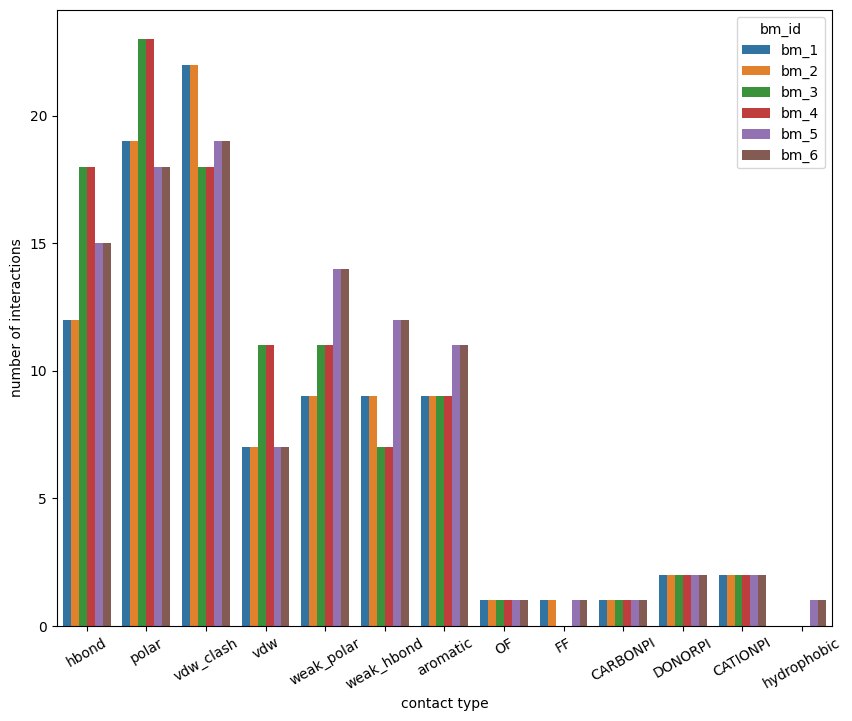

In [109]:
# Generate a count-plot of contact types
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.countplot(pdb_inx_non_proximal, x="contact_type", hue="bm_id")
plt.xticks(rotation=30)
plt.xlabel("contact type")
plt.ylabel("number of interactions")
plt.show()

 - From the contact-type count plot, it is clear that the most of the interactions are polar, and there are very less number of hydrophobic interactions. This is in aggrement with the location of binding site - interface of proteins in the outer surface.
 - Equivalent bound-molecules (bound-molecules from the symmetric subunits) have the same interaction pattern (bm1-bm2, bm3-bm4, and bm5-bm6 ) as expected
 - atom-plane and plane-plane interactions are same in all instances of ligands

In [112]:
bound_molecules[0].is_equivalent(bound_molecules[1])

True

In [114]:
bound_molecules[0].is_equivalent(bound_molecules[2])

False

In [113]:
bound_molecules[2].is_equivalent(bound_molecules[3])

True

In [ ]:
def summarise_bm_interactions(interactions_df, bm_id):
  m

In [135]:
pdb_inx_non_proximal[(pdb_inx_non_proximal["bm_id"]=="bm_1") & (pdb_inx_non_proximal["contact_type"]=="hbond") & (pdb_inx_non_proximal["interacting_entities"]=="INTER")]

,interacting_entities,interaction_type,distance,bm_id,contact_type,auth_asym_id_1,auth_asym_id_2,auth_seq_id_1,auth_seq_id_2,label_comp_id_1,label_comp_id_2,auth_atom_id_1,auth_atom_id_2
2,INTER,atom-atom,3.17,bm_1,hbond,A,C_2,700,252,APC,SER,O1G,OG
55,INTER,atom-atom,2.79,bm_1,hbond,A,A,700,137,APC,THR,O2A,N
116,INTER,atom-atom,2.98,bm_1,hbond,A,A,700,136,APC,LYS,O1A,N
180,INTER,atom-atom,3.35,bm_1,hbond,A,A,700,136,APC,LYS,O2A,N


In [136]:
pdb_inx_non_proximal[(pdb_inx_non_proximal["bm_id"]=="bm_1") & (pdb_inx_non_proximal["contact_type"]=="polar") & (pdb_inx_non_proximal["interacting_entities"]=="INTER")]

,interacting_entities,interaction_type,distance,bm_id,contact_type,auth_asym_id_1,auth_asym_id_2,auth_seq_id_1,auth_seq_id_2,label_comp_id_1,label_comp_id_2,auth_atom_id_1,auth_atom_id_2
3,INTER,atom-atom,3.17,bm_1,polar,A,C_2,700,252,APC,SER,O1G,OG
56,INTER,atom-atom,2.79,bm_1,polar,A,A,700,137,APC,THR,O2A,N
64,INTER,atom-atom,3.07,bm_1,polar,A,A,700,137,APC,THR,O2A,OG1
117,INTER,atom-atom,2.98,bm_1,polar,A,A,700,136,APC,LYS,O1A,N
181,INTER,atom-atom,3.35,bm_1,polar,A,A,700,136,APC,LYS,O2A,N
297,INTER,atom-atom,3.46,bm_1,polar,A,A,700,288,APC,TYR,N9,OH
403,INTER,atom-atom,2.86,bm_1,polar,A,A,700,292,APC,SER,N7,OG
411,INTER,atom-atom,3.26,bm_1,polar,A,A,700,292,APC,SER,N6,OG


In [137]:
pdb_inx_non_proximal[(pdb_inx_non_proximal["bm_id"]=="bm_1") & (pdb_inx_non_proximal["contact_type"]=="vdw") & (pdb_inx_non_proximal["interacting_entities"]=="INTER")].head()

,interacting_entities,interaction_type,distance,bm_id,contact_type,auth_asym_id_1,auth_asym_id_2,auth_seq_id_1,auth_seq_id_2,label_comp_id_1,label_comp_id_2,auth_atom_id_1,auth_atom_id_2
29,INTER,atom-atom,3.28,bm_1,vdw,A,A,700,160,APC,GLU,O2G,CD
63,INTER,atom-atom,3.07,bm_1,vdw,A,A,700,137,APC,THR,O2A,OG1
244,INTER,atom-atom,3.47,bm_1,vdw,A,C_2,700,278,APC,GLN,C4,CG
278,INTER,atom-atom,3.44,bm_1,vdw,A,A,700,288,APC,TYR,C2,CE2
304,INTER,atom-atom,3.43,bm_1,vdw,A,A,700,288,APC,TYR,C4,CZ


In [139]:
pdb_inx_non_proximal[(pdb_inx_non_proximal["bm_id"]=="bm_3") & (pdb_inx_non_proximal["contact_type"]=="hbond") & (pdb_inx_non_proximal["interacting_entities"]=="INTER")]

,interacting_entities,interaction_type,distance,bm_id,contact_type,auth_asym_id_1,auth_asym_id_2,auth_seq_id_1,auth_seq_id_2,label_comp_id_1,label_comp_id_2,auth_atom_id_1,auth_atom_id_2
1077,INTER,atom-atom,2.41,bm_3,hbond,B,B,700,137,APC,THR,O2A,N
1096,INTER,atom-atom,3.27,bm_3,hbond,B,B,700,234,APC,ASN,O1A,ND2
1106,INTER,atom-atom,3.50,bm_3,hbond,B,B,700,288,APC,TYR,O4',OH
1126,INTER,atom-atom,3.52,bm_3,hbond,B,B,700,136,APC,LYS,O1A,N
1143,INTER,atom-atom,3.17,bm_3,hbond,B,B,700,234,APC,ASN,O2G,ND2
1169,INTER,atom-atom,3.00,bm_3,hbond,B,B,700,136,APC,LYS,O2A,N
1250,INTER,atom-atom,2.78,bm_3,hbond,B,B,700,292,APC,SER,N7,OG
1256,INTER,atom-atom,3.27,bm_3,hbond,B,B,700,292,APC,SER,N6,OG
1456,INTER,atom-atom,3.45,bm_3,hbond,B,B,700,288,APC,TYR,N9,OH


In [ ]:
pdb_interactions_df[(pdb_interactions_df["bm_id"]=="bm_1") & (pdb_interactions_df["contact_type"]=="hbond") & (pdb_interactions_df["interacting_entities"]=="INTER")].head()

#&nbsp; 3 PDBe RelLig

With over 200,000 entries in the PDB, about 75% of these structures contain at least one ligand bound to a protein or nucleic acid. However, not all ligands are biologically relevant, some are present due to experimental necessities, such as aiding crystallisation or enabling cryoprotection, while others play biologically significant roles acting as cofactors, reactants or drugs. Unfortunately, the biological role of ligands present in PDB entries is not annotated in the PDB/mmCIF files.
PDBe RelLig is designed to bridge this gap by automatically annotating the ligand's functional role as the following:
 - cofactor
 - reactant
 - drug